# CSI Workshop 1: RECIPE PRODUCTION PROCESS IMPROVEMENT

### BusAdm 745 - ARTIFICIAL INTELLIGENCE FOR BUSINESS​

Problem: Roughly 16% of observation vials in our lab dataset failed weigh check inspections. Our goal is to determine the factors that impact whether a vial will pass or fail weigh check inspection and then to build a model which can predict whether a vial will pass or fail based on those factors.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

## Load and Preprocess Data

The data for this analysis is the provided by a network of connected industrial devices and sensors in the CSI manufacturing cell. Each observation represents a production vial that entered the assembly line. Sensors track location and station processes, including weight and visual inspection stations processes.



In [2]:
# Load the dataset
# data = pd.read_csv(r'C:\Users\webste63\Downloads\Data Workshop 1 Apr 6 2023.csv')

# Read csv into pandas dataframe
data = pd.read_csv('C:/Users/mlhen/Downloads/Data Workshop 1 Apr 6 2023.csv')

# Preprocess the data
data = data[data['ManualRecipeNumber'] == 1]
data = data[data['InspectStationWeighCheckPassFail'] != 0]

# Remove datetimestamps from dataset
# Remove columns designating upper and lower inspection thresholds
# Remove unique identifier columns 
# Remove columns with only 1 value
# Also remove 'MESScheduleUniqueID' column
cols_to_remove = []
for col in data.columns:
    if 'Time' in col:
        cols_to_remove.append(f'{col}')
    elif 'Upper' in col:
        cols_to_remove.append(f'{col}')
    elif 'Lower' in col:
        cols_to_remove.append(f'{col}')
    elif len(data[col].unique()) == 1:
        cols_to_remove.append(f'{col}')
    elif len(data[col].unique()) == len(data):
        cols_to_remove.append(f'{col}')
    elif col == 'MESScheduleUniqueID':
        cols_to_remove.append(f'{col}')
    
data = data.drop(cols_to_remove, axis=1)

In [3]:
data.info()
print('\nPropotion of Pass(1) and Fail(2) for Inspect Station Weight Check:')
print(f'Out of {len(data)} observations.\n')
print(data['InspectStationWeighCheckPassFail'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 1 to 305
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CurrentVehicleID                  132 non-null    int64  
 1   InspectStationVisionComplete      132 non-null    int64  
 2   InspectStationVisionDuration      132 non-null    int64  
 3   InspectStationVisionOpRequired    132 non-null    int64  
 4   InspectStationVisionPassFail      132 non-null    int64  
 5   InspectStationVisionVialRGBBlue   132 non-null    int64  
 6   InspectStationVisionVialRGBGreen  132 non-null    int64  
 7   InspectStationVisionVialRGBRed    132 non-null    int64  
 8   InspectStationWeighCheckData      132 non-null    float64
 9   InspectStationWeighCheckDuration  132 non-null    int64  
 10  InspectStationWeighCheckPassFail  132 non-null    int64  
 11  Station1ChecknLoadDuration        132 non-null    int64  
 12  UnloadDu

Notable that the proportion of our intended variable is approximately 84% positive, meaning that 84% of observations in our dataset did pass the weigh check inspection. 

## Feature Selection

In [4]:
# Define the target and features
target = 'InspectStationWeighCheckPassFail'
features = data.drop(columns=[target])

# Perform feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=10)
selector.fit(features, data[target])
selected_features = features.columns[selector.get_support()]

print("Selected features:", list(selected_features))

Selected features: ['InspectStationVisionComplete', 'InspectStationVisionDuration', 'InspectStationVisionOpRequired', 'InspectStationVisionVialRGBBlue', 'InspectStationVisionVialRGBGreen', 'InspectStationVisionVialRGBRed', 'InspectStationWeighCheckData', 'UnloadDuration', 'WetFillStation3VolumeDispTank3', 'WetFillStation3VolumeDispTank4']


## Train Random Forest Classifier

In [5]:
# Train-test split (75%-25%)
X_train, X_test, y_train, y_test = train_test_split(features[selected_features], data[target], test_size=0.25, random_state=42, stratify=data[target])

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Perform 10-fold cross-validation on the training set
cv = StratifiedKFold(n_splits=10)
roc_aucs = []

for train_index, val_index in cv.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    clf.fit(X_train_cv, y_train_cv)
    y_val_pred = clf.predict_proba(X_val_cv)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val_cv, y_val_pred, pos_label=2)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)

print("Mean AUC after 10-fold cross-validation:", np.mean(roc_aucs))

Mean AUC after 10-fold cross-validation: 0.975


In [6]:
# Train the classifier on the entire training set
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

## Evaluate Model

In [7]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00         5

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

Confusion Matrix:
 [[28  0]
 [ 0  5]]


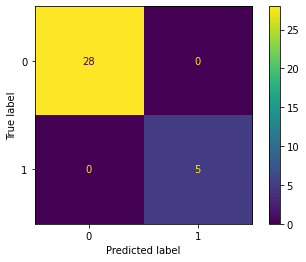

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

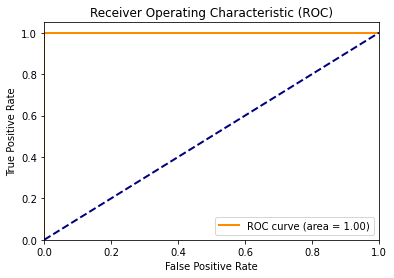

In [9]:
# Calculate AUC and plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

On this particular dataset, our Random Forest Classifier Model performed with complete accuracy, zero false positives and false negatives, and the area under our ROC curve was 1.00. While this performance is ideal, it it worth noting that the dataset is quite small and we expect that accuracy would decrease on an larger sample. 

## Use Model to Make Predictions Using Test Data

In [10]:
# Show predictions for the test data
print("\nPredictions for the test data:")
print("Actual values  :", np.array(y_test))
print("Predicted values:", y_pred)


Predictions for the test data:
Actual values  : [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1]
Predicted values: [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1]


## Learnings - Post Workshop Reflections

Throughout the course of this workshop, one of the challenges we encountered as a team was a lack of familiarity and contextual understanding of the data. This, coupled with the vastness of data collected by the CSI AI-based manufacturing system, made it particularly difficult to know which features to use in our analysis. We'll include some of the process that went into refining our model here. 

In [11]:
# Initial concept explored: Build a regression model to predict whether a vial will pass or fail weigh check inspection 
# using WetFillStation3Duration as input:

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Read csv into pandas dataframe
df = pd.read_csv('C:/Users/mlhen/Downloads/Data Workshop 1 Apr 6 2023.csv')

# Select columns relevant to analysis
df1 = df[['MESScheduleUniqueID', 'ManualRecipeNumber', 'WetFillStation3Duration', 
          'InspectStationWeighCheckPassFail']] #'InspectStationVisionPassFail'

# Filter to one recipe and remove observation that did not complete the inspection
df1 = df1[df1['ManualRecipeNumber']==1]
df1 =  df1[df1['InspectStationWeighCheckPassFail']!=0]

# Assign features and target to X and y
X = df1[['WetFillStation3Duration']].to_numpy()
y = df1['InspectStationWeighCheckPassFail']

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=417)


# Train a linear regression model on the training set
LinReg = LinearRegression().fit(X_train, y_train)
r_sq = LinReg.score(X_train, y_train)
print(f'Coefficient of determination: {r_sq}')


# Train a logistic regression model on the training set
logreg = LogisticRegression().fit(X_train, y_train)
score = logreg.score(X_train, y_train)
print(f'Score: {score}')

Coefficient of determination: 0.08079575427097607
Score: 0.8285714285714286


Considering that, based on the weigh check station pass rate of 84% for the entire dataset, it is likely that predicting a pass for all observations would have achieved scores consistent with our regressions models. Therefore, the decision was made to employ feature selection modules to help determine which variables has the greatest impact on weigh check pass rate. 

In [12]:
# Read csv into pandas dataframe
data1 = pd.read_csv('C:/Users/mlhen/Downloads/Data Workshop 1 Apr 6 2023.csv')

# Preprocess the data
data1 = data1[data1['ManualRecipeNumber'] == 1]
data1 = data1[data1['InspectStationWeighCheckPassFail'] != 0]

# Identify datetime column(s) and convert them to Unix timestamps
datetime_columns = [col for col in data1.columns if re.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{3}Z', str(data1[col].iloc[0]))]
for col in datetime_columns:
    data1[col] = pd.to_datetime(data1[col]).astype(np.int64) // 10**9
    
# Drop non-numeric columns
numeric_data = data1.select_dtypes(include=[np.number])
data1 = numeric_data.copy()

data1.reset_index(drop=True, inplace=True)

# Define the target and features
target = 'InspectStationWeighCheckPassFail'
features = data1.drop(columns=[target])

# Perform feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=10)
selector.fit(features, data1[target])
selected_features = features.columns[selector.get_support()]

print("Selected features:", list(selected_features))

C:\Users\mlhen\AppData\Local\Temp/ipykernel_15592/2765409295.py:11: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data1[col] = pd.to_datetime(data1[col]).astype(np.int64) // 10**9


Selected features: ['t', 'InspectStationVisionFinishTimeDay', 'InspectStationVisionStartTimeDay', 'InspectStationVisionVialRGBBlue', 'InspectStationWeighCheckLowerLimit', 'InspectStationWeighCheckUpperLimit', 'Station1FinishTimeHour', 'UnloadFinishTimeHour', 'WetFillStation3FinishTimeHour', 'WetFillStation3VolumeDispTank3']


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features[selected_features], data[target], test_size=0.3, random_state=42)

# Train a classifier (Random Forest as an example)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.925
Classification Report:
               precision    recall  f1-score   support

           1       0.91      1.00      0.96        32
           2       1.00      0.62      0.77         8

    accuracy                           0.93        40
   macro avg       0.96      0.81      0.86        40
weighted avg       0.93      0.93      0.92        40

Confusion Matrix:
 [[32  0]
 [ 3  5]]


In [14]:
# Show predictions for the test data
print("\nPredictions for the test data:")
print("Actual values  :", np.array(y_test))
print("Predicted values:", y_pred)


Predictions for the test data:
Actual values  : [1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1
 1 1 1]
Predicted values: [1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1
 1 1 1]


In addition to the feature selection methods, we used a ensemble Random Forest Classifier model in hopes to reduce the impact of the bias in the dataset. The second experimental model we trained using the features selected by the scikit-learn feature selection module made a marked improvement in accuracy, however, upon reviewing the feature inputs, we noticed that many of those feature selected were related to date or time. Upon closer inspection, there really wasn't much of a range for dates and times in the dataset, so it seemed like it would be hard to derive meaningful patterns by focusing on those features - specifically, given the limited size of the dataset.

By using some common logic to filter the dataset, removing columns with no variation, too much variation (unique ids), and with datetime data, we were able to greatly improve upon the model performance. Lastly, an assumption was made that upper and lower limits used in inspection steps were likely to be fixed by industry or product standards and so removed those columns, as well. 

## Benefits that the manufacturing plant would derive 

Leveraging AI to identify variables that impact likelihood of quality inspection failure can help manufacturers to improve overall production quality and yield by: ​

​

Identifying areas needing for process improvement​

Reducing cost associated with defective product delivery​

Driving consistent delivery​

Informing quality assurance guidelines that produce the best possible end-products​